<h1><center>Popularity based Recommender - Amazon Beauty Products</center></h1>

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

Read the cleaned file into dataframes.

In [2]:
meta = pd.read_csv('cleaned_metadata.csv',index_col=0)
reviews = pd.read_csv('cleaned_reviews.csv',index_col=0)

In [3]:
meta.head(2)

,asin,description,price,brand_title,health_personal_care,beauty,main_cat,sub_cat,related_count
0,0205616461,as age youthful healthy skin succumbs enzymatic imbalance wears away cellular network resulting skin thinning aging combining best nature cosmetic biotechnology bioactive products formulated enzymes gently exfoliate skin stimulate regeneration youthful glow benefiting fertile orchards italian countryside bioactive formulas rich phytohormones flavonoids fatty acids active extracts apple pear seeds enzymatically modified developed especially care aging skin this repairing fluid helps nourish firm accelerating penetration delivery active principles skin giving youthful appearance advanced probiotic complex nourishing milk proteins regains skins natural equilibrium boosts immunities protects environmental biological stress peptides ceramides help firm regenerate skin stimulating collagen production strengthening epidermis a calming botanical complex hyaluronic acid wheat germ extract hydrates restores skins protective barriers a nutritive vitamin complex moisturizes protects skin damaging environmental factors paracress extract natural alternative cosmetic injections limits relaxes microcontractions create facial lines producing immediate longterm smoothing skin to use apply pumps apply pumps clean dried face neck dcollet,NaN,Bio-Active Anti-Aging Serum (Firming Ultra-Hydrati,461765.0,-1.0,Skin Care,Face,0.0
1,0558925278,mineral powder brushapply powder mineral foundation face circular buffing motion work inward towards nose concealer brushuse liquid mineral powder concealer coverage blemishes eyes eye shading brush expertly cut apply blend powder eye shadows baby kabuki buff powder areas need coverage cosmetic brush bag 55 hemp linen 45 cotton,NaN,Eco Friendly Ecotools Quality Natural Bamboo Cosme,-1.0,402875.0,Tools & Accessories,Makeup Brushes & Tools,0.0


In [4]:
reviews.head(2)

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
0,A39HTATAQ9V7YF,0205616461,5,2013-05-28,bioactive antiaging serum love moisturizer would recommend someone dry skin fine lines wrinkles using brand day night serum,0,0,34,0.283333
1,A3JM6GV9MNOF9X,0558925278,3,2012-12-14,product ok im use baby kabuki moment received product deadlinei tested baby kabuki quality material best packaging cute love itthe fibers smell soft,0,1,44,0.520000


In [5]:
print("Products:",meta.shape)
print("Reviews:",reviews.shape)

Products: (259204, 9)
Reviews: (2023070, 9)


In [6]:
meta.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259204 entries, 0 to 259203
Data columns (total 9 columns):
asin                    259204 non-null object
description             259137 non-null object
price                   189930 non-null float64
brand_title             258760 non-null object
health_personal_care    259204 non-null float64
beauty                  259204 non-null float64
main_cat                259204 non-null object
sub_cat                 259204 non-null object
related_count           259204 non-null float64
dtypes: float64(4), object(5)
memory usage: 19.8+ MB


In [7]:
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023070 entries, 0 to 2023069
Data columns (total 9 columns):
reviewerID    2023070 non-null object
asin          2023070 non-null object
overall       2023070 non-null int64
reviewTime    2023070 non-null object
review        2023067 non-null object
upvotes       2023070 non-null int64
downvotes     2023070 non-null int64
word_count    2023070 non-null int64
polarity      2023070 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 154.3+ MB


In [8]:
reviews[reviews['review'].isnull()]

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
1360701,A1LF7KGH427GYC,B00552467Q,5,2014-07-08,NaN,0,0,2,0.0
1467181,AUII249W6FBZY,B00604MV0C,3,2013-01-11,NaN,0,0,2,0.0
1784718,A3BX2SSKN9SFRV,B00ADXZ9LY,1,2014-07-03,NaN,0,0,4,0.0


In [9]:
d = {5: "Excellent", 4:"Very Good", 3: "Good", 2:"Not Good", 1: "Bad"}
s = reviews.overall.map(d)
reviews['review'] = reviews['review'].combine_first(s)

In [10]:
reviews.loc[1784718]

reviewerID    A3BX2SSKN9SFRV
asin          B00ADXZ9LY    
overall       1             
reviewTime    2014-07-03    
review        Bad           
upvotes       0             
downvotes     0             
word_count    4             
polarity      0             
Name: 1784718, dtype: object

In [11]:
reviews[reviews['asin']=='0558925278']

,reviewerID,asin,overall,reviewTime,review,upvotes,downvotes,word_count,polarity
1,A3JM6GV9MNOF9X,0558925278,3,2012-12-14,product ok im use baby kabuki moment received product deadlinei tested baby kabuki quality material best packaging cute love itthe fibers smell soft,0,1,44,0.520
2,A1Z513UWSAAO0F,0558925278,5,2014-07-07,love set love set great buy price dont wear makeup time love feels,0,0,31,0.575


In [12]:
meta['description'][54107]

nan

In [13]:
reviews['review'] = reviews['review'].str.strip()

In [14]:
meta['description'] = meta['description'].fillna(meta['main_cat'])
meta['brand_title'] = meta['brand_title'].fillna(meta['main_cat'])
meta['price'] = meta['price'].fillna(0)

### Popularity-based Recommender

This is the simplest recommendation system. As is obvious from the name, it simply recommends the popular and highly rated items to all the users. The bigest drawback of this system is that it is non-personalized and recommends the same items to everyone. Since users' have different tastes and preferences, this is not a very useful filtering method.

One way of measuring popularity is by counting the number of times an item was rated. Higher the rating count, more popular the item is.

In [15]:
rating_count = pd.DataFrame(reviews.groupby('asin')['overall'].count())
rc_df = rating_count.rename(index=str, columns={"overall": "rev_cnt"})
rc_df.sort_values('rev_cnt', ascending=False).head()

,rev_cnt
asin,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088


In [16]:
rating_avg = pd.DataFrame(reviews.groupby('asin')['overall'].mean())
ra_df = rating_avg.rename(index=str, columns={"overall": "rev_avg"})
ra_df.sort_values('rev_avg', ascending=False).head()

,rev_avg
asin,
0205616461,5.0
B00551HYQC,5.0
B0054ZSIXC,5.0
B00550UX52,5.0
B00550YQP0,5.0


In [17]:
pol_df = pd.DataFrame(reviews.groupby('asin')['polarity'].mean())
pol_df.sort_values('polarity', ascending=False).head()

,polarity
asin,
B006ZZSB1E,1.0
B004SYNFE2,1.0
B001OGQXSC,1.0
B005CK2H1I,1.0
B009CPDQ1O,1.0


In [18]:
meta_df = meta.merge(rc_df, on='asin')
meta_df = meta_df.merge(ra_df, on='asin')
meta_df = meta_df.merge(pol_df, on='asin')
meta_df.head(2)

,asin,description,price,brand_title,health_personal_care,beauty,main_cat,sub_cat,related_count,rev_cnt,rev_avg,polarity
0,0205616461,as age youthful healthy skin succumbs enzymatic imbalance wears away cellular network resulting skin thinning aging combining best nature cosmetic biotechnology bioactive products formulated enzymes gently exfoliate skin stimulate regeneration youthful glow benefiting fertile orchards italian countryside bioactive formulas rich phytohormones flavonoids fatty acids active extracts apple pear seeds enzymatically modified developed especially care aging skin this repairing fluid helps nourish firm accelerating penetration delivery active principles skin giving youthful appearance advanced probiotic complex nourishing milk proteins regains skins natural equilibrium boosts immunities protects environmental biological stress peptides ceramides help firm regenerate skin stimulating collagen production strengthening epidermis a calming botanical complex hyaluronic acid wheat germ extract hydrates restores skins protective barriers a nutritive vitamin complex moisturizes protects skin damaging environmental factors paracress extract natural alternative cosmetic injections limits relaxes microcontractions create facial lines producing immediate longterm smoothing skin to use apply pumps apply pumps clean dried face neck dcollet,0.0,Bio-Active Anti-Aging Serum (Firming Ultra-Hydrati,461765.0,-1.0,Skin Care,Face,0.0,1,5.0,0.283333
1,0558925278,mineral powder brushapply powder mineral foundation face circular buffing motion work inward towards nose concealer brushuse liquid mineral powder concealer coverage blemishes eyes eye shading brush expertly cut apply blend powder eye shadows baby kabuki buff powder areas need coverage cosmetic brush bag 55 hemp linen 45 cotton,0.0,Eco Friendly Ecotools Quality Natural Bamboo Cosme,-1.0,402875.0,Tools & Accessories,Makeup Brushes & Tools,0.0,2,4.0,0.547500


In [19]:
most_rated_items = pd.DataFrame(['B001MA0QY2', 'B0009V1YR8', 'B0043OYFKU', 'B0000YUXI0', 'B003V265QW'], index=np.arange(5), columns=['asin'])
summary = pd.merge(most_rated_items, meta, on='asin')
summary

,asin,description,price,brand_title,health_personal_care,beauty,main_cat,sub_cat,related_count
0,B001MA0QY2,the proffesional hsi flat iron great transforming frizzy dull hair gorgeously straight sleek locks aside straightening proffesional hsi flat iron curls flips hair beautifully 1 plates giving maximum control hair types with flash quick heating swivel cord iron provides great style without making mess taking much time featuring new easier grip ergonomic design easier hold styler flat iron also versatile heat settings provide total control hairstyling needs moist ceramic heat solid ceramic plates coils maintain even temperature,53.59,HSI PROFESSIONAL HSI PROFESSIONAL 1 CERAMIC TOURMA,-1.0,1.0,Hair Care,Styling Tools,0.0
1,B0009V1YR8,farouk chi gf1001 original 1 ceramic ionic flat iron hair straightener warranty offer all chi products purchased direct amazoncom covered 30 day amazon warranty this item covered manufacture warranty applies products sold amazoncom does apply products sold site thirdparty merchants thirdparty areas amazoncom marketplace auctions,89.09,Farouk CHI 1 Inch Ceramic Flat Hairstyling Iron,-1.0,3128.0,Hair Care,Styling Tools,90.0
2,B0043OYFKU,no description,26.99,Olay Olay Pro-X Advanced Cleansing System 0.68 Fl,-1.0,6.0,Skin Care,Face,0.0
3,B0000YUXI0,a transparent formula distinct bitter taste discourage nail biting putting fingers mouth,10.59,MAVALA Mavala Stop - Helps Cure Nail Biting and Th,-1.0,16.0,Skin Care,Hands & Nails,0.0
4,B003V265QW,no description,27.77,Remington Remington CI95AC/2 Tstudio Salon Collect,-1.0,73.0,Hair Care,Styling Tools,0.0


In [20]:
related = pd.DataFrame(meta.groupby('asin')['related_count'].max())
related.sort_values('related_count', ascending=False).head()

,related_count
asin,
B005BF1M10,3937.0
B004TSFBNK,3727.0
B001TK1I4M,3640.0
B00150LT40,3603.0
B008GOR6O0,3398.0


In [21]:
beauty_rank = pd.DataFrame(meta.groupby('asin')['beauty'].max())
beauty_rank[beauty_rank['beauty'] > 0].sort_values('beauty').head()

,beauty
asin,
B001MA0QY2,1.0
B0012BNVE8,2.0
B00I46E8DC,5.0
B0043OYFKU,6.0
B000FS05VG,6.0


In [22]:
hpc_rank = pd.DataFrame(meta.groupby('asin')['health_personal_care'].max())
hpc_rank[hpc_rank['health_personal_care'] > 0].sort_values('health_personal_care').head()

,health_personal_care
asin,
B00GP184WO,123.0
B0013TM9UQ,142.0
B00DHQCJTO,180.0
B00DM14TYC,187.0
B000ELP5KA,240.0


#### Using Weighted average for each item's Average Rating

In [23]:
v=meta_df['rev_cnt']
R=meta_df['rev_avg']
C=meta_df['rev_avg'].mean()
m=meta_df['rev_cnt'].quantile(0.70)

In [24]:
meta_df['w_avg']=((R*v)+ (C*m))/(v+m)

In [25]:
meta_df[meta_df['asin'] == 'B001MA0QY2']

,asin,description,price,brand_title,health_personal_care,beauty,main_cat,sub_cat,related_count,rev_cnt,rev_avg,polarity,w_avg
65765,B001MA0QY2,the proffesional hsi flat iron great transforming frizzy dull hair gorgeously straight sleek locks aside straightening proffesional hsi flat iron curls flips hair beautifully 1 plates giving maximum control hair types with flash quick heating swivel cord iron provides great style without making mess taking much time featuring new easier grip ergonomic design easier hold styler flat iron also versatile heat settings provide total control hairstyling needs moist ceramic heat solid ceramic plates coils maintain even temperature,53.59,HSI PROFESSIONAL HSI PROFESSIONAL 1 CERAMIC TOURMA,-1.0,1.0,Hair Care,Styling Tools,0.0,7533,4.321386,0.306972,4.321295


In [26]:
meta_df_rank = meta_df.sort_values('w_avg',ascending=False).reset_index()
meta_df_rank[['asin', 'brand_title', 'rev_cnt', 'rev_avg', 'w_avg']].head(20)

,asin,brand_title,rev_cnt,rev_avg,w_avg
0,B004CNRDBU,Zoya Zoya Remove Plus Nail Polish Remover 32 oz,58,5.000000,4.945113
1,B00K7ER6LU,Travel Packing Cubes- 4pc Set With Free &hearts; S,85,4.976471,4.939292
2,B001F0RBRE,"Dr. Bronner Dr. Bronner's Sal Suds, 32-Ounce Bottl",41,5.000000,4.924378
3,B00FPROWWU,Kabuki Brush By Simply Essentials. Today Only 50%,79,4.962025,4.922855
4,B004AI5756,"Moisturel Moisturel Therapeutic Lotion, Dry Sensit",38,5.000000,4.918976
5,B00466VJ04,BaBylissPRO Nano Titanium - Blue - Straightening I,38,5.000000,4.918976
6,B002YFN49I,Sara Monica Flower Hair Clip and Pin Rose_Made in,98,4.948980,4.917618
7,B005V247N8,Sigma Synthetic Essential Kit 8 Brushes,37,5.000000,4.917000
8,B00KH6F6TM,Best Bentonite Clay - Top Healing Clay - Finest Az,58,4.965517,4.912855
9,B009OWSHQE,Active Accessories On-The-Go Accessory Pouch (Blac,88,4.943182,4.908663


Text(0, 0.5, 'Product Brand')

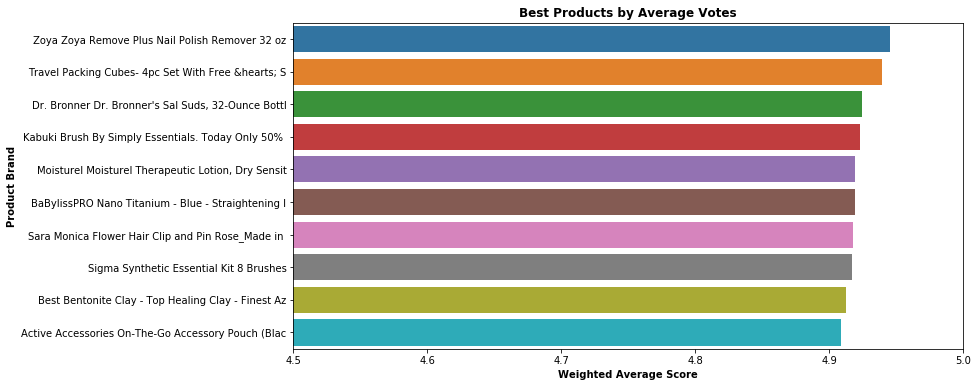

In [27]:
weight_average=meta_df_rank.sort_values('w_avg',ascending=False)
plt.figure(figsize=(12,6))
axis1=sns.barplot(x=weight_average['w_avg'].head(10), y=weight_average['brand_title'].head(10), data=weight_average)
plt.xlim(4.5, 5)
plt.title('Best Products by Average Votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Product Brand', weight='bold')

Text(0, 0.5, 'Product Brand')

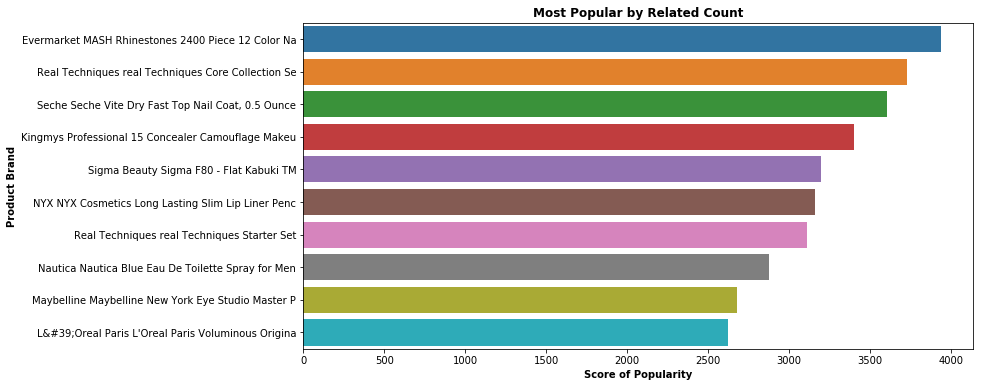

In [28]:
related=meta_df_rank.sort_values('related_count',ascending=False)
plt.figure(figsize=(12,6))
ax=sns.barplot(x=related['related_count'].head(10), y=related['brand_title'].head(10), data=related)

plt.title('Most Popular by Related Count', weight='bold')
plt.xlabel('Score of Popularity', weight='bold')
plt.ylabel('Product Brand', weight='bold')

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaling=MinMaxScaler()
meta_scaled_df=scaling.fit_transform(meta_df[['w_avg','related_count']])
meta_normalized_df=pd.DataFrame(meta_scaled_df,columns=['w_avg','related_count'])
meta_normalized_df.head()

,w_avg,related_count
0,0.816092,0.0
1,0.751460,0.0
2,0.757309,0.0
3,0.580958,0.0
4,0.816092,0.0


In [30]:
meta_df[['nw_avg','nw_rel']]= meta_normalized_df

In [31]:
meta_df['score'] = meta_df['nw_avg'] * 0.5 + meta_df['nw_rel'] * 0.5
meta_score = meta_df.sort_values(['score'], ascending=False)
meta_score[['asin', 'brand_title', 'nw_avg', 'nw_rel', 'score']].head(20)

,asin,brand_title,nw_avg,nw_rel,score
128164,B004TSFBNK,Real Techniques real Techniques Core Collection Se,0.926674,0.946660,0.936667
138437,B005BF1M10,Evermarket MASH Rhinestones 2400 Piece 12 Color Na,0.791300,1.000000,0.895650
47159,B00150LT40,"Seche Seche Vite Dry Fast Top Nail Coat, 0.5 Ounce",0.850513,0.915164,0.882838
104575,B003UH0528,Sigma Beauty Sigma F80 - Flat Kabuki TM,0.921137,0.811786,0.866461
128165,B004TSFE28,Real Techniques real Techniques Starter Set,0.908970,0.789942,0.849456
96545,B003EBNLIA,NYX NYX Cosmetics Long Lasting Slim Lip Liner Penc,0.840050,0.802642,0.821346
115090,B004B3YC9M,OPI OPI Natural Nail Base Coat &amp; Top Coat COMB,0.906797,0.633223,0.770010
72895,B0022V2PKI,Nautica Nautica Blue Eau De Toilette Spray for Men,0.770543,0.729743,0.750143
157485,B006UET4XE,Maybelline Maybelline New York Eye Studio Master P,0.818725,0.679959,0.749342
46028,B0013TM9UQ,"Now Foods NOW Solutions Castor Oil, 100 % Pure, 16",0.880467,0.555753,0.718110


Text(0, 0.5, 'Product Brand')

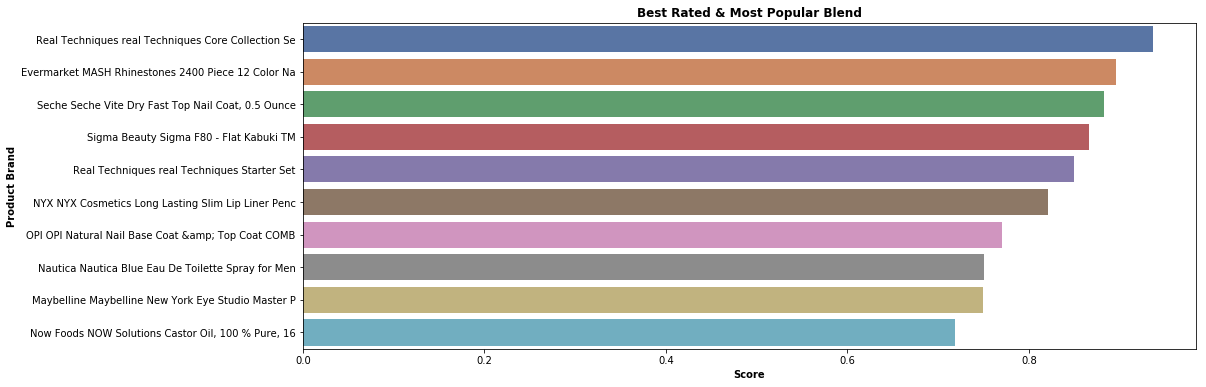

In [32]:
scored_df = meta_df.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored_df['score'].head(10), y=scored_df['brand_title'].head(10), data=scored_df, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Product Brand', weight='bold')

In [33]:
reviews_df = meta_df.merge(reviews, on='asin')